In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Reshape
import numpy as np


In [2]:
def count_kmers(sequence, k):
    kmer_counts = {}
    for i in range(len(sequence) - k + 1):
        kmer = tuple(sequence[i:i+k])  # Convert the sublist of integers into a tuple
        kmer_counts[kmer] = kmer_counts.get(kmer, 0) + 1
    return kmer_counts



In [3]:
# Load CSV data into a DataFrame

virus_files = {
    'SARS-CoV-2': '2sars cov_2.csv',
    'SARS-CoV-1': 'Sars_cov_1.csv',
    'Ebola': 'Ebola.csv',
    'Dengue': 'Dengue.csv',
    'Influenza': 'Influenza.csv',
    'MERS-CoV': 'Mers_cov.csv'
}

all_data = []

for virus_name, file_path in virus_files.items():
    df_combined = pd.read_csv(file_path)
    df_combined['Virus_Name'] = virus_name  # Add virus name as a column
    all_data.append(df_combined)

# Combine all DataFrames into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

output_csv_file = "pd.csv"
df_combined.to_csv(output_csv_file, index=False)
print(f"DataFrame with virus names saved to {output_csv_file}")



DataFrame with virus names saved to pd.csv


In [4]:
# Preprocess Sequences
df_combined['Sequence'] = df_combined['Sequence'].apply(lambda x: x.replace('N', ''))



In [5]:
# Calculate and print the average sequence length before padding
average_sequence_length = df_combined['Sequence'].apply(len).mean()
print(f"Average Sequence Length before padding: {average_sequence_length}")

# Pad sequences to the maximum length
max_sequence_length = df_combined['Sequence'].apply(len).max()
print(f"max Sequence Length before padding: {max_sequence_length}")
df_combined['Padded_Sequence'] = df_combined['Sequence'].apply(lambda x: x.ljust(max_sequence_length, 'N'))


Average Sequence Length before padding: 16459.958912386708
max Sequence Length before padding: 30484


In [6]:
def integer_encoding(seq):
    base_dict = {'A': 1, 'T': 2, 'C': 3, 'G': 4, 'N': 0}  # Assign integers to each nucleotide
    return [base_dict.get(base, 0) for base in seq]  # Return integer-encoded sequence
df_combined['Integer_Encoded_Sequence'] = df_combined['Sequence'].apply(integer_encoding)


In [7]:
# Apply the k-mer counting function to each padded sequence
kmer_length = 3  # Specify the k-mer length
df_combined['Kmer_Counts'] = df_combined['Integer_Encoded_Sequence'].apply(lambda seq: count_kmers(seq, kmer_length))

# Create a global dictionary to sum up all counts of unique k-mers across sequences
global_kmer_counts = {}
for index, row in df_combined.iterrows():
    for kmer, count in row['Kmer_Counts'].items():
        global_kmer_counts[kmer] = global_kmer_counts.get(kmer, 0) + count

# Print unique k-mers along with their total counts
for kmer, count in global_kmer_counts.items():
    print(f"K-mer: {kmer}, Count: {count}")

K-mer: (3, 3, 1), Count: 2124513
K-mer: (3, 1, 1), Count: 3772870
K-mer: (1, 1, 3), Count: 3237863
K-mer: (1, 3, 3), Count: 2040689
K-mer: (1, 3, 2), Count: 3494171
K-mer: (3, 2, 2), Count: 3773119
K-mer: (2, 2, 2), Count: 5068495
K-mer: (2, 2, 3), Count: 2781047
K-mer: (2, 3, 4), Count: 701560
K-mer: (3, 4, 1), Count: 626935
K-mer: (4, 1, 2), Count: 2487349
K-mer: (1, 2, 3), Count: 1909114
K-mer: (2, 3, 2), Count: 2929121
K-mer: (3, 2, 3), Count: 1713514
K-mer: (2, 2, 4), Count: 4286375
K-mer: (2, 4, 2), Count: 4384591
K-mer: (4, 2, 1), Count: 2375803
K-mer: (2, 1, 4), Count: 2227925
K-mer: (1, 4, 1), Count: 3385226
K-mer: (3, 2, 4), Count: 2730204
K-mer: (4, 2, 2), Count: 3595438
K-mer: (3, 2, 1), Count: 2900179
K-mer: (2, 1, 1), Count: 3600093
K-mer: (1, 1, 1), Count: 4784797
K-mer: (1, 3, 4), Count: 983169
K-mer: (4, 1, 1), Count: 3135454
K-mer: (2, 2, 1), Count: 4328059
K-mer: (1, 1, 2), Count: 3982771
K-mer: (4, 2, 4), Count: 2974701
K-mer: (2, 4, 4), Count: 3251643
K-mer: (4, 4,

In [8]:

# Save the DataFrame with the new 'Kmer_Counts' and 'Padded_Sequence' columns to a new CSV file
output_csv_file = "kmer_pd.csv"
df_combined.to_csv(output_csv_file, index=False)

# Display a message indicating where the output CSV file is saved
print(f"DataFrame with padded sequences and k-mer counts saved to {output_csv_file}")

DataFrame with padded sequences and k-mer counts saved to kmer_pd.csv


In [9]:
# Create vocabulary from global k-mer counts
vocabulary = list(global_kmer_counts.keys())
vocab_size = len(vocabulary)
kmer_to_index = {kmer: i for i, kmer in enumerate(vocabulary)}

In [10]:
# Function to convert k-mer counts to vector
def sequence_to_vector(sequence_kmer_counts):
    vector = np.zeros(vocab_size)
    for kmer, count in sequence_kmer_counts.items():
        kmer_index = kmer_to_index.get(kmer, None)
        if kmer_index is not None:
            vector[kmer_index] = count
    return vector

In [11]:
# Create vectors for each sequence
df_combined['Vectorized_Sequences'] = df_combined['Kmer_Counts'].apply(sequence_to_vector)



In [12]:
# Prepare data for the model
X = np.stack(df_combined['Vectorized_Sequences'].values)
# y = df_combined['Virus_Name'].map({'SARS-CoV-2': 0, 'Other_Virus': 1}).values
# y = to_categorical(y)  # Convert labels to one-hot encoding
# Determine the unique virus names in the dataset
unique_virus_names = df_combined['Virus_Name'].unique()

# Map each virus name to an integer index
label_mapping = {virus_name: i for i, virus_name in enumerate(unique_virus_names)}

# Map the labels using the updated label mapping
y = df_combined['Virus_Name'].map(label_mapping).values

# Convert labels to one-hot encoding
num_classes = len(unique_virus_names)
y = to_categorical(y, num_classes=num_classes)

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Define and train the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(vocab_size,)),
    Dropout(0.5),
    Reshape((256, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)



Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 96s 666ms/step - accuracy: 0.4028 - loss: 1.3268 - val_accuracy: 0.5824 - val_loss: 0.9406
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 669ms/step - accuracy: 0.5853 - loss: 0.9060 - val_accuracy: 0.6264 - val_loss: 0.7455
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 81s 726ms/step - accuracy: 0.6387 - loss: 0.7211 - val_accuracy: 0.6440 - val_loss: 0.7123
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 78s 695ms/step - accuracy: 0.6362 - loss: 0.7035 - val_accuracy: 0.6692 - val_loss: 0.6597
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 77s 685ms/step - accuracy: 0.6521 - loss: 0.6778 - val_accuracy: 0.6528 - val_loss: 0.6784
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 75s 672ms/step - accuracy: 0.6580 - loss: 0.6613 - val_accuracy: 0.6579 - val_loss: 0.6541
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 677ms/step - accuracy: 0.6586 - loss: 0.6516 - val_accuracy: 0.6616 - val_loss: 0.6431
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 72s 643ms/step - accuracy: 0.6547 - loss: 0

In [16]:
# Save the trained model
model.save("trained_model.h5")


In [32]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.7134 - loss: 0.5075
Test Accuracy: 0.7180261611938477


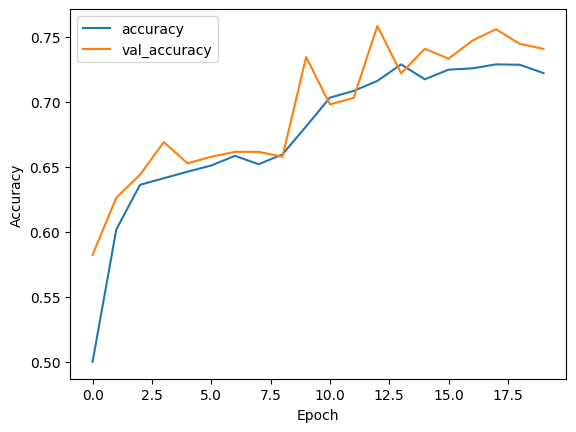

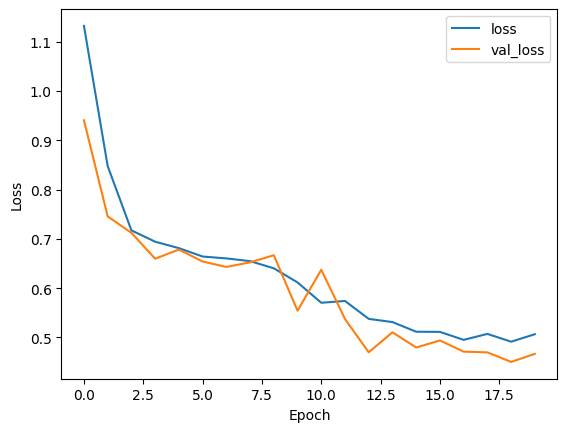

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming history is the actual History object
plot_history(history)


In [18]:
def preprocess_sequence(sequence, kmer_length):
    # Remove 'N' characters
    sequence = sequence.replace('N', '')
    # Pad sequence to match the maximum k-mer length used during training
    padded_sequence = sequence.ljust(max_sequence_length, 'N')
    # Integer encode the sequence
    integer_encoded_sequence = integer_encoding(padded_sequence)
    # Count k-mers
    sequence_kmer_counts = count_kmers(integer_encoded_sequence, kmer_length)
    # Convert k-mer counts to vector
    sequence_vector = sequence_to_vector(sequence_kmer_counts)
    return sequence_vector

def predict_virus(sequence, model, kmer_length, label_mapping, max_sequence_length):
    # Preprocess the raw sequence
    sequence_vector = preprocess_sequence(sequence, kmer_length)

    # Reshape the sequence vector to match the input shape of the model
    sequence_vector = sequence_vector.reshape(1, -1)

    # Print all classes of viruses and their indices
    print("All classes of viruses:")
    for index, virus_name in label_mapping.items():
        print(f"Index: {index}, Virus: {virus_name}")


    # Predict virus type using the model
    predicted_probabilities = model.predict(sequence_vector)
    predicted_class_index = np.argmax(predicted_probabilities)
    print("Predicted class index:", predicted_class_index)  # Print the predicted class index
    predicted_virus = label_mapping[predicted_class_index]

    return predicted_virus


In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("trained_model.h5")

# Example usage
test_sequence = "CCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGGTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTTCTGAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTTCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGAGACTCATTGATGCTATGATGTTCACATCTGATTTGGCTACTAACAATCTAGTTGTAATGGCCTACATTACAGGTGGTGTTGTTCAGTTGACTTCGCAGTGGCTAACTAACATCTTTGGCACTGTTTATGAAAAACTCAAACCCGTCCTTGATTGGCTTGAAGAGAAGTTTAAGGAAGGTGTAGAGTTTCTTAGAGACGGTTGGGAAATTGTTAAATTTATCTCAACCTGTGCTTGTGAAATTGTCGGTGGACAAATTGTCACCTGTGCAAAGGAAATTAAGGAGAGTGTTCAGACATTCTTTAAGCTTGTAAATAAATTTTTGGCTTTGTGTGCTGACTCTATCATTATTGGTGGAGCTAAACTTAAAGCCTTGAATTTAGGTGAAACATTTGTCACGCACTCAAAGGGATTGTACAGAAAGTGTGTTAAATCCAGAGAAGAAACTGGCCTACTCATGCCTCTAAAAGCCCCAAAAGAAATTATCTTCTTAGAGGGAGAAACACTTCCCACAGAAGTGTTAACAGAGGAAGTTGTCTTGAAAACTGGTGATTTACAACCATTAGAACAACCTACTAGTGAAGCTGTTGAAGCTCCATTGGTTGGTACACCAGTTTGTATTAACGGGCTTATGTTGCTCGAAATCAAAGACACAGAAAAGTACTGTGCCCTTGCACCTAATATGATGGTAACAAACAATACCTTCACACTCAAAGGCGGTGCACCAACAAAGGTTACTTTTGGTGATGACACTGTGATAGAAGTGCAAGGTTACAAGAGTGTGAATATCATTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTACTTACACCACTGGGCATTGATTTAGATGAGTGGAGTATGGCTACATACTACTTATTTGATGAGTCTGGTGAGTTTAAATTGGCTTCACATATGTATTGTTCTTTTTACCCTCCAGATGAGGATGAAGAAGAAGGTGATTGTGAAGAAGAAGAGTTTGAGCCATCAACTCAATATGAGTATGGTACTGAAGATGATTACCAAGGTAAACCTTTGGAATTTGGTGCCACTTCTGCTGCTCTTCAACCTGAAGAAGAGCAAGAAGAAGATTGGTTAGATGATGATAGTCAACAAACTGTTGGTCAACAAGACGGCAGTGAGGACAATCAGACAACTACTATTCAAACAATTGTTGAGGTTCAACCTCAATTAGAGATGGAACTTACACCAGTTGTTCAGACTATTGAAGTGAATAGTTTTAGTGGTTATTTAAAACTTACTGACAATGTATACATTAAAAATGCAGACATTGTGGAAGAAGCTAAAAAGGTAAAACCAACAGTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGTAGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAAGAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTGCTGACCCTATACATTCTTTAAGAGTTTGTGTAGATACTGTTCGCACAAATGTCTACTTAGCTGTCTTTGATAAAAATCTCTATGACAAACTTGTTTCAAGCTTTTTGGAAATGAAGAGTGAAAAGCAAGTTGAACAAAAGATCGCTGAGATTCCTAAAGAGGAAGTTAAGCCATTTATAACTGAAAGTAAACCTTCAGTTGAACAGAGAAAACAAGATGATAAGAAAATCAAAGCTTGTGTTGAAGAAGTTACAACAACTCTGGAAGAAACTAAGTTCCTCACAGAAAACTTGTTACTTTATATTGACATTAATGGCAATCTTCATCCAGATTCTGCCACTCTTGTTAGTGACATTGACATCACTTTCTTAAAGAAAGATGCTCCATATATAGTGGGTGATGTTGTTCAAGAGGGTGTTTTAACTGCTGTGGTTATACCTACTAAAAAGGCTAGTGGCACTACTGAAATGCTAGCGAAAGCTTTGAGAAAAGTGCCAACAGACAATTATATAACCACTTACCCGGGTCAGGGTTTAAATGGTTACACTGTAGAGGAGGCAAAGACAGTGCTTAAAAAGTGTAAAAGTGCTTTTTACATTCTACCATCTATTATCTCTAATGAGAAGCAAGAAATTCTTGGAACTGTTTCTTGGAATTTGCGAGAAATGCTTGCACATGCAGAAGAAACACGCAAATTAATGCCTGTCTGTGTGGAAACTAAAGCCATAGTTTCAACTATACAGCGTAAATATAAGGGTATTAAAATACAAGAGGGTGTGGTTGATTATGGTGCTAGATTTTACTTTTACACCAGTAAAACAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACTCTTGTTACAATGCCACTTGGCTATGTAACACATGGCTTAAATTTGGAAGAAGCTGCTCGGTATATGAGATCTCTCAAAGTGCCAGCTACAGTTTCTGTTTCTTCACCTGATGCTGTTACAGCGTATAATGGTTATCTTACTTCTTCTTCTAAAACACCTGAAGAACATTTTATTGAAACCATCTCACTTGCTGGTTCCTATAAAGATTGGTCCTATTCTGGACAATCTACACAACTAGGTATAGAATTTCTTAAGAGAGGTGATAAAAGTGTATATTACACTAGTAATCCTACCACATTCCACCTAGATGGTGAAGTTATCACCTTTGACAATCTTAAGACACTTCTTTCTTTGAGAGAAGTGAGGACTATTAAGGTGTTTACAACAGTAGACAACATTAACCTCCACACGCAAGTTGTGGACATGTCAATGACATATGGACAACAGTTTGGTCCAACTTATTTGGATGGAGCTGATGTTACTAAAATAAAACCTCATAATTCACATGAAGGTAAAACATTTTATGTTTTACCTAATGATGACACTCTACGTGTTGAGGCTTTTGAGTACTACCACACAACTGATCCTAGTTTTCTGGGTAGGTACATGTCAGCATTAAATCACACTAAAAAGTGGAAATACCCACAAGTTAATGGTTTAACTTCTATTAAATGGGCAGATAACAACTGTTATCTTGCCACTGCATTGTTAACACTCCAACAAATAGAGTTGAAGTTTAATCCACCTGCTCTACAAGATGCTTATTACAGAGCAAGGGCTGGTGAAGCTGCTAACTTTTGTGCACTTATCTTAGCCTACTGTAATAAGACAGTAGGTGAGTTAGGTGATGTTAGAGAAACAATGAGTTACTTGTTTCAACATGCCAATTTAGATTCTTGCAAAAGAGTCTTGAACGTGGTGTGTAAAACTTGTGGACAACAGCAGACAACCCTTAAGGGTGTAGAAGCTGTTATGTACATGGGCACACTTTCTTATGAACAATTTAAGAAAGGTGTTCAGATACCTTGTACGTGTGGTAAACAAGCTACAAAATATCTAGTACAACAGGAGTCACCTTTTGTTATGATGTCAGCACCACCTGTTCAGTATGAACTTAAGCATGGTACATTTACTTGTGCTAGTGAGTACACTGGTAATTACCAGTGTGGTCACTATAAACATATAACTTCTAAAGAAACTTTGTATTGCATAGACGGTGCTTTACTTACAAAGTCCTCAGAATACAAAGGTCCTATTACGGATGTTTTCTACAAAGAAAACAGTTACACAACAACCATAAAACCAGTTACTTATAAATTGGATGGTGTTGTTTGTACAGAAATTGACCCTAAGTTGGACAATTATTATAAGAAAGACAATTCTTATTTCACAGAGCAACCAATTGATCTTGTACCAAACCAACCATATCCAAACGCAAGCTTCGATAATTTTAAGTTTGTATGTGATAATATCAAATTTGCTGATGATTTAAACCAGTTAACTGGTTATAAGAAACCTGCTTCAAGAGAGCTTAAAGTTACATTTTTCCCTGACTTAAATGGTGATGTGGTGGCTATTGATTATAAACACTACACACCCTCTTTTAAGAAAGGAGCTAAATTGTTACATAAACCTATTGTTTGGCATGTTAACAATGCAACTAATAAAGCCACGTATAAACCAAATACCTGGTGTATACGTTGTCTTTGGAGCACAAAACCAGTTGAAACATCAAATTCGTTTGATGTACTGAAGTCAGAGGACGCGCAGGGAATGGATAATCTTGCCTGCGAAGATCTAAAACCAGTCTCTGAAGAAGTAGTGGAAAATCCTACCATACAGAAAGACGTTCTTGAGTGTAATGTGAAAACTACCGAAGTTGTAGGAGACATTATACTTAAACCAGCAAATAATAGTTTAAAAATTACAGAAGAGGTTGGCCACACAGATCTAATGGCTGCTTATGTAGACAATTCTAGTCTTACTATTAAGAAACCTAATGAATTATCTAGAGTATTAGGTTTGAAAACCCTTGCTACTCATGGTTTAGCTGCTGTTAATAGTGTCCCTTGGGATACTATAGCTAATTATGCTAAGCCTTTTCTTAACAAAGTTGTTAGTACAACTACTAACATAGTTACACGGTGTTTAAACCGTGTTTGTACTAATTATATGCCTTATTTCTTTACTTTATTGCTACAATTGTGTACTTTTACTAGAAGTACAAATTCTAGAATTAAAGCATCTATGCCGACTACTATAGCAAAGAATACTGTTAAGAGTGTCGGTAAATTTTGTCTAGAGGCTTCATTTAATTATTTGAAGTCACCTAATTTTTCTAAACTGATAAATATTATAATTTGGTTTTTACTATTAAGTGTTTGCCTAGGTTCTTTAATCTACTCAACCGCTGCTTTAGGTGTTTTAATGTCTAATTTAGGCATGCCTTCTTACTGTACTGGTTACAGAGAAGGCTATTTGAACTCTACTAATGTCACTATTGCAACCTACTGTACTGGTTCTATACCTTGTAGTGTTTGTCTTAGTGGTTTAGATTCTTTAGACACCTATCCTTCTTTAGAAACTATACAAATTACCATTTCATCTTTTAAATGGGATTTAACTGCTTTTGGCTTAGTTGCAGAGTGGTTTTTGGCATATATTCTTTTCACTAGGTTTTTCTATGTACTTGGATTGGCTGCAATCATGCAATTGTTTTTCAGCTATTTTGCAGTACATTTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTACAAATGGCCCCGATTTCAGCTATGGTTAGAATGTACATCTTCTTTGCATCATTTTATTATGTATGGAAAAGTTATGTGCATGTTGTAGACGGTTGTAATTCATCAACTTGTATGATGTGTTACAAACGTAATAGAGCAACAAGAGTTGAATGTACAACTATTGTTAATGGTGTTAGAAGGTCCTTTTATGTCTATGCTAATGGAGGTAAAGGCTTTTGCAAACTACACAATTGGAATTGTGTTAATTGTGATACATTCTGTGCTGGTAGTACATTTATTAGTGATGAAGTTGCGAGAGACTTGTCACTACAGTTTAAAAGACCAATAAATCCTACTGACCAGTCTTCTTACATCGTTGATAGTGTTACAGTGAAGAATGGTTCCATCCATCTTTACTTTGATAAAGCTGGTCAAAAGACTTATGAAAGACATTCTCTCTCTCATTTTGTTAACTTAGACAACCTGAGAGCTAATAACACTAAAGGTTCATTGCCTATTAATGTTATAGTTTTTGATGGTAAATCAAAATGTGAAGAATCATCTGCAAAATCAGCGTCTGTTTACTACAGTCAGCTTATGTGTCAACCTATACTGTTACTAGATCAGGCATTAGTGTCTGATGTTGGTGATAGTGCGGAAGTTGCAGTTAAAATGTTTGATGCTTACGTTAATACGTTTTCATCAACTTTTAACGTACCAATGGAAAAACTCAAAACACTAGTTGCAACTGCAGAAGCTGAACTTGCAAAGAATGTGTCCTTAGACAATGTCTTATCTACTTTTATTTCAGCAGCTCGGCAAGGGTTTGTTGATTCAGATGTAGAAACTAAAGATGTTGTTGAATGTCTTAAATTGTCACATCAATCTGACATAGAAGTTACTGGCGATAGTTGTAATAACTATATGCTCACCTATAACAAAGTTGAAAACATGACACCCCGTGACCTTGGTGCTTGTATTGACTGTAGTGCGCGTCATATTAATGCGCAGGTAGCAAAAAGTCACAACATTGCTTTGATATGGAACGTTAAAGATTTCATGTCATTGTCTGAACAACTACGAAAACAAATACGTAGTGCTGCTAAAAAGAATAACTTACCTTTTAAGTTGACATGTGCAACTACTAGACAAGTTGTTAATGTTGTAACAACAAAGATAGCACTTAAGGGTGGTAAAATTGTTAATAATTGGTTGAAGCAGTTAATTAAAGTTACACTTGTGTTCCTTTTTGTTGCTGCTATTTTCTATTTAATAACACCTGTTCATGTCATGTCTAAACATACTGACTTTTCAAGTGAAATCATAGGATACAAGGCTATTGATGGTGGTGTCACTCGTGACATAGCATCTACAGATACTTGTTTTGCTAACAAACATGCTGATTTTGACACATGGTTTAGCCAGCGTGGTGGTAGTTATACTAATGACAAAGCTTGCCCATTGATTGCTGCAGTCATAACAAGAGAAGTGGGTTTTGTCGTGCCTGGTTTGCCTGGCACGATATTACGCACAACTAATGGTGACTTTTTGCATTTCTTACCTAGAGTTTTTAGTGCAGTTGGTAACATCTGTTACACACCATCAAAACTTATAGAGTACACTGACTTTGCAACATCAGCTTGTGTTTTGGCTGCTGAATGTACAATTTTTAAAGATGCTTCTGGTAAGCCAGTACCATATTGTTATGATACCAATGTACTAGAAGGTTCTGTTGCTTATGAAAGTTTACGCCCTGACACACGTTATGTGCTCATGGATGGCTCTATTATTCAATTTCCTAACACCTACCTTGAAGGTTCTGTTAGAGTGGTAACAACTTTTGATTCTGAGTACTGTAGGCACGGCACTTGTGAAAGATCAGAAGCTGGTGTTTGTGTATCTACTAGTGGTAGATGGGTACTTAACAATGATTATTACAGATCTTTACCAGGAGTTTTCTGTGGTGTAGATGCTGTAAATTTATTTACTAATATGTTTACACCACTAATTCAACCTATTGGTGCTTTGGACATATCAGCATCTATAGTAGCTGGTGGTATTGTGGCTATCGTAGTAACATGCCTTGCCTACTATTTTATGAGGTTTAGAAGAGCTTTTGGTGAATACAGTCATGTAGTTGCCTTTAATACTTTACTATTCCTTATGTCATTCATTGTACTCTGTTTAACACCAGTTTACTCATTCTTACCTGGTGTTTATTCTGTTATTTACTTGTACTTGACATTTTATCTTACTAATGATGTTTCTTTTTTAGCACATATTCAGTGGATGGTTATGTTCACACCTTTAGTACCTTTCTGGATAACAATTGCTTATATCATTTGTATTTCCACAAAGCATTTCTATTGGTTCTTTAGTAATTACCTAAAGAGACGTGTAGTCTTTAATGGTGTTTCCTTTAGTACTTTTGAAGAAGCTGCGCTGTGCACCTTTTTGTTAAATAAAGAAATGTATCTAAAGTTGCGTAGTGATGTGCTATTACCTCTTACGCAATATAATAGATACTTAGCTCTTTATAATAAGTACAAGTATTTTAGTGGAGCAATGGATACAACTAGCTACAGAGAAGCTGCTTGTTGTCATCTCGCAAAGGCTCTCAATGACTTCAGTAACTCAGGTTCTGATGTTCTTTACCAACCACCACAAATCTCTATCACCTCAGCTGTTTTGCAGAGTGGTTTTAGAAAAATGGCATTCCCATCTGGTAAAGTTGAGGGTTGTATGGTACAAGTAACTTGTGGTACAACTACACTTAACGGTCTTTGGCTTGATGACGTAGTTTACTGTCCAAGACATGTGATCTGCACCTCTGAAGATATGCTTAACCCTAATTATGAAGATTTACTCATTCGTAAGTCTAATCATAATTTCTTGGTACAGGCTGGTAATGTTCAACTCAGGGTTATTGGACATTCTATGCAAAATTGTGTACTTAAGCTTAAGGTTGATACAGCCAATCCTAAGACACCTAAGTATAAGTTTGTTCGCATTCAACCAGGACAGACTTTTTCAGTGTTAGCTTGTTACAATGGTTCACCATCTGGTGTTTACCAATGTGCTATGAGACACAATTTCACTATTAAGGGTTCATTCCTTAATGGTTCATGTGGTAGTGTTGGTTTTAACATAGATTATGACTGTGTCTCTTTTTGTTACATGCACCATATGGAATTACCAACTGGAGTTCATGCTGGCACAGACTTAGAAGGTAACTTTTATGGACCTTTTGTTGACAGGCAAACAGCACAAGCAGCTGGTACGGACACAACTATTACAGTTAATGTTTTAGCTTGGTTGTACGCTGCTGTTATAAATGGAGACAGGTGGTTTCTCAATCGATTTACCACAACTCTTAATGACTTTAACCTTGTGGCTATGAAGTACAATTATGAACCTCTAACACAAGACCATGTTGACATACTAGGACCTCTTTCTGCTCAAACTGGAATTGCCGTTTTAGATATGTGTGCTTCATTAAAAGAATTACTGCAAAATGGTATGAATGGACGTACCATATTGGGTAGTGCTTTATTAGAAGATGAATTTACACCTTTTGATGTTGTTAGACAATGCTCAGGTGTTACTTTCCAAAGTGCAGTGAAAAGAACAATCAAGGGTACACACCACTGGTTGTTACTCACAATTTTGACTTCACTTTTAGTTTTAGTCCAGAGTACTCAATGGTCTTTGTTCTTTTTTTTGTATGAAAATGCCTTTTTACCTTTTGCTATGGGTATTATTGCTATGTCTGCTTTTGCAATGATGTTTGTCAAACATAAGCATGCATTTCTCTGTTTGTTTTTGTTACCTTCTCTTGCCACTGTAGCTTATTTTAATATGGTCTATATGCCTGCTAGTTGGGTGATGCGTATTATGACATGGTTGGATATGGTTGATACTAGTTTGAAGCTAAAAGACTGTGTTATGTATGCATCAGCTGTAGTGTTACTAATCCTTATGACAGCAAGAACTGTGTATGATGATGGTGCTAGGAGAGTGTGGACACTTATGAATGTCTTGACACTCGTTTATAAAGTTTATTATGGTAATGCTTTAGATCAAGCCATTTCCATGTGGGCTCTTATAATCTCTGTTACTTCTAACTACTCAGGTGTAGTTACAACTGTCATGTTTTTGGCCAGAGGTATTGTTTTTATGTGTGTTGAGTATTGCCCTATTTTCTTCATAACTGGTAATACACTTCAGTGTATAATGCTAGTTTATTGTTTCTTAGGCTATTTTTGTACTTGTTACTTTGGCCTCTTTTGTTTACTCAACCGCTACTTTAGACTGACTCTTGGTGTTTATGATTACTTAGTTTCTACACAGGAGTTTAGATATATGAATTCACAGGGACTACTCCCACCCAAGAATAGCATAGATGCCTTCAAACTCAACATTAAATTGTTGGGTGTTGGTGGCAAACCTTGTATCAAAGTAGCCACTGTACAGTCTAAAATGTCAGATGTAAAGTGCACATCAGTAGTCTTACTCTCAGTTTTGCAACAACTCAGAGTAGAATCATCATCTAAATTGTGGGCTCAATGTGTCCAGTTACACAATGACATTCTCTTAGCTAAAGATACTACTGAAGCCTTTGAAAAAATGGTTTCACTACTTTCTGTTTTGCTTTCCATGCAGGGTGCTGTAGACATAAACAAGCTTTGTGAAGAAATGCTGGACAACAGGGCAACCTTACAAGCTATAGCCTCAGAGTTTAGTTCCCTTCCATCATATGCAGCTTTTGCTACTGCTCAAGAAGCTTATGAACAGGCTGTTACTAATGGTGATTCTGAAGTTGTTCTTAAAAAGTTGAAGAAGTCTTTGAATGTGGCTAAATCTGAATTTGACCGTGATGCAGCCATGCAACGTAAGTTGGAAAAGATGGCTGATCAAGCTATGACCCAAATGTATAAACAGGCTAGATCTGAGGACAAGAGGGCAAAAGTTACTAGTGCTATGCAGACAATGCTTTTCACTATGCTTAGAAAGTTGGATAATGATGCACTCAACAACATTATCAACAATGCAAGAGATGGTTGTGTTCCCTTGAACATAATACCTCTTACAACAGCAGCCAAACTAATGGTTGTCATACCAGACTATAACACATATAAAAATACGTGTGATGGTACAACATTTACTTATGCATCAGCATTGTGGGAAATCCAACAGGTTGTAGATGCAGATAGTAAAATTGTTCAACTTAGTGAAATTAGTATGGACAATTCACCTAATTTAGCATGGCCTCTTATTGTAACAGCTTTAAGGGCCAATTCTGCTGTCAAATTACAGAATAATGAGCTTAGTCCTGTTGCACTACGACAGATGTCTTGTGCTGCCGGTACTACACAAACTGCTTGCACTGATGACAATGCGTTAGCTTACTACAACACAACAAAGGGAGGTAGGTTTGTACTTGCACTGTTATCCGATTTACAGGATTTGAAATGGGCTAGATTCCCTAAGAGTGATGGAACTGGTACTATTTATACAGAACTGGAACCACCTTGTAGGTTTGTTACAGACACACCTAAAGGTCCTAAAGTGAAGTATTTATACTTTATTAAAGGATTAAACAACCTAAATAGAGGTATGGTACTTGGTAGTTTAGCTGCCACAGTACGTCTACAAGCTGGTAATGCAACAGAAGTGCCTGCCAATTCAACTGTATTATCTTTCTGTGCTTTTGCTGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGACAACCAATCACTAATTGTGTTAAGATGTTGTGTACACACACTGGTACTGGTCAGGCAATAACAGTTACACCGGAAGCCAATATGGATCAAGAATCCTTTGGTGGTGCATCGTGTTGTCTGTACTGCCGTTGCCACATAGATCATCCAAATCCTAAAGGATTTTGTGACTTAAAAGGTAAGTATGTACAAATACCTACAACTTGTGCTAATGACCCTGTGGGTTTTACACTTAAAAACACAGTCTGTACCGTCTGCGGTATGTGGAAAGGTTATGGCTGTAGTTGTGATCAACTCCGCGAACCCATGCTTCAGTCAGCTGATGCACAATCGTTTTTAAACGGGTTTGCGGTGTAAGTGCAGCCCGTCTTACACCGTGCGGCACAGGCACTAGTACTGATGTCGTATACAGGGCTTTTGACATCTACAATGATAAAGTAGCTGGTTTTGCTAAATTCCTAAAAACTAATTGTTGTCGCTTCCAAGAAAAGGACGAAGATGACAATTTAATTGATTCTTACTTTGTAGTTAAGAGACACACTTTCTCTAACTACCAACATGAAGAAACAATTTATAATTTACTTAAGGATTGTCCAGCTGTTGCTAAACATGACTTCTTTAAGTTTAGAATAGACGGTGACATGGTACCACATATATCACGTCAACGTCTTACTAAATACACAATGGCAGACCTCGTCTATGCTTTAAGGCATTTTGATGAAGGTAATTGTGACACATTAAAAGAAATACTTGTCACATACAATTGTTGTGATGATGATTATTTCAATAAAAAGGACTGGTATGATTTTGTAGAAAACCCAGATATATTACGCGTATACGCCAACTTAGGTGAACGTGTACGCCAAGCTTTGTTAAAAACAGTACAATTCTGTGATGCCATGCGAAATGCTGGTATTGTTGGTGTACTGACATTAGATAATCAAGATCTCAATGGTAACTGGTATGATTTCGGTGATTTCATACAAACCACGCCAGGTAGTGGAGTTCCTGTTGTAGATTCTTATTATTCATTGTTAATGCCTATATTAACCTTGACCAGGGCTTTAACTGCAGAGTCACATGTTGACACTGACTTAACAAAGCCTTACATTAAGTGGGATTTGTTAAAATATGACTTCACGGAAGAGAGGTTAAAACTCTTTGACCGTTATTTTAAATATTGGGATCAGACATACCACCCAAATTGTGTTAACTGTTTGGATGACAGATGCATTCTGCATTGTGCAAACTTTAATGTTTTATTCTCTACAGTGTTCCCACTTACAAGTTTTGGACCACTAGTGAGAAAAATATTTGTTGATGGTGTTCCATTTGTAGTTTCAACTGGATACCACTTCAGAGAGCTAGGTGTTGTACATAATCAGGATGTAAACTTACATAGCTCTAGACTTAGTTTTAAGGAATTACTTGTGTATGCTGCTGACCCTGCTATGCACGCTGCTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGTAGCTGCACTTACTAACAATGTTGCTTTTCAAACTGTCAAACCCGGTAATTTTAACAAAGACTTCTATGACTTTGCTGTGTCTAAGGGTTTCTTTAAGGAAGGAAGTTCTGTTGAATTAAAACACTTCTTCTTTGCTCAGGATGGTAATGCTGCTATCAGCGATTATGACTACTATCGTTATAATCTACCAACAATGTGTGATATCAGACAACTACTATTTGTAGTTGAAGTTGTTGATAAGTACTTTGATTGTTACGATGGTGGCTGTATTAATGCTAACCAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTAATAAATGGGGTAAGGCTAGACTTTATTATGATTCAATGAGTTATGAGGATCAAGATGCACTTTTCGCATATACAAAACGTAATGTCATCCCTACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTCTCTATCTGTAGTACTATGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAATAGCCGCCACTAGAGGAGCTACTGTAGTAATTGGAACAAGCAAATTCTATGGTGGTTGGCACAACATGTTAAAAACTGTTTATAGTGATGTAGAAAACCCTCACCTTATGGGTTGGGATTATCCTAAATGTGATAGAGCCATGCCTAACATGCTTAGAATTATGGCCTCACTTGTTCTTGCTCGCAAACATACAACGTGTTGTAGCTTGTCACACCGTTTCTATAGATTAGCTAATGAGTGTGCTCAAGTATTGAGTGAAATGGTCATGTGTGGCGGTTCACTATATGTTAAACCAGGTGGAACCTCATCAGGAGATGCCACAACTGCTTATGCTAATAGTGTTTTTAACATTTGTCAAGCTGTCACGGCCAATGTTAATGCACTTTTATCTACTGATGGTAACAAAATTGCCGATAAGTATGTCCGCAATTTACAACACAGACTTTATGAGTGTCTCTATAGAAATAGAGATGTTGACACAGACTTTGTGAATGAGTTTTACGCATATTTGCGTAAACATTTCTCAATGATGATACTTTCTGACGATGCTGTTGTGTGTTTCAATAGCACTTATGCATCTCAAGGTCTAGTGGCTAGCATAAAGAACTTTAAGTCAGTTCTTTATTATCAAAACAATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTACTAAAGGACCTCATGAATTTTGCTCTCAACATACAATGCTAGTTAAACAGGGTGATGATTATGTGTACCTTCCTTACCCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACTTATGATTGAACGGTTCGTGTCTTTAGCTATAGATGCTTACCCACTTACTAAACATCCTAATCAGGAGTATGCTGATGTCTTTCATTTGTACTTACAATACATAAGAAAGCTACATGATGAGTTAACAGGACACATGTTAGACATGTATTCTGTTATGCTTACTAATGATAACACTTCAAGGTATTGGGAACCTGAGTTTTATGAGGCTATGTACACACCGCATACAGTCTTACAGGCTGTTGGGGCTTGTGTTCTTTGCAATTCACAGACTTCATTAAGATGTGGTGCTTGCATACGTAGACCATTCTTATGTTGTAAATGCTGTTACGACCATGTCATATCAACATCACATAAATTAGTCTTGTCTGTTAATCCGTATGTTTGCAATGCTCCAGGTTGTGATGTCACAGATGTGACTCAACTTTACTTAGGAGGTATGAGCTATTATTGTAAATCACATAAACCACCCATTAGTTTTCCATTGTGTGCTAATGGACAAGTTTTTGGTTTATATAAAAATACATGTGTTGGTAGCGATAATGTTACTGACTTTAATGCAATTGCAACATGTGACTGGACAAATGCTGGTGATTACATTTTAGCTAACACCTGTACTGAAAGACTCAAGCTTTTTGCAGCAGAAACGCTCAAAGCTACTGAGGAGACATTTAAACTGTCTTATGGTATTGCTACTGTACGTGAAGTGCTGTCTGACAGAGAATTACATCTTTCATGGGAAGTTGGTAAACCTAGACCACCACTTAACCGAAATTATGTCTTTACTGGTTATCGTGTAACTAAAAACAGTAAAGTACAAATAGGAGAGTACACCTTTGAAAAAGGTGACTATGGTGATGCTGTTGTTTACCGAGGTACAACAACTTACAAATTAAATGTTGGTGATTATTTTGTGCTGACATCACATACAGTAATGCCATTAAGTGCACCTACACTAGTGCCACAAGAGCACTATGTTAGAATTACTGGCTTATACCCAACACTCAATATCTCAGATGAGTTTTCTAGCAATGTTGCAAATTATCAAAAGGTTGGTATGCAAAAGTATTCTACACTCCAGGGACCACCTGGTACTGGTAAGAGTCATTTTGCTATTGGCCTAGCTCTCTACTACCCTTCTGCTCGCATAGTGTATACAGCTTGCTCTCATGCCGCTGTTGATGCACTATGTGAGAAGGCATTAAAATATTTGCCTATAGATAAATGTAGTAGAATTATACCTGCACGTGCTCGTGTAGAGTGTTTTGATAAATTCAAAGTGAATTCAACATTAGAACAGTATGTCTTTTGTACTGTAAATGCATTGCCTGAGACGACAGCAGATATAGTTGTCTTTGATGAAATTTCAATGGCCACAAATTATGATTTGAGTGTTGTCAATGCCAGATTATGTGCTAAGCACTATGTGTACATTGGCGACCCTGCTCAATTACCTGCACCACGCACATTGCTAACTAAGGGCACACTAGAACCAGAATATTTCAATTCAGTGTGTAGACTTATGAAAACTATAGGTCCAGACATGTTCCTCGGAACTTGTCGGCGTTGTCCTGCTGAAATTGTTGACACTGTGAGTGCTTTGGTTTATGATAATAAGCTTAAAGCACATAAAGACAAATCAGCTCAATGCTTTAAAATGTTTTATAAGGGTGTTATCACGCATGATGTTTCATCTGCAATTAACAGGCCACAAATAGGCGTGGTAAGAGAATTCCTTACACGTAACCCTGCTTGGAGAAAAGCTGTCTTTATTTCACCTTATAATTCACAGAATGCTGTAGCCTCAAAGATTTTGGGACTACCAACTCAAACTGTTGATTCATCACAGGGCTCAGAATATGACTATGTCATATTCACTCAAACCACTGAAACAGCTCACTCTTGTAATGTAAACAGATTTAATGTTGCTATTACCAGAGCAAAAGTAGGCATACTTTGCATAATGTCTGATAGAGACCTTTATGACAAGTTGCAATTTACAAGTCTTGAAATTCCACGTAGGAATGTGGCAACTTTACAAGCTGAAAATGTAACAGGACTCTTTAAAGATTGTAGTAAGGTAATCACTGGGTTACATCCTACACAGGCACCTACACACCTCAGTGTTGACACTAAATTCAAAACTGAAGGTTTATGTGTTGACGTACCTGGCATACCTAAGGACATGACCTATAGAAGACTCATCTCTATGATGGGTTTTAAAATGAATTATCAAGTTAATGGTTACCCTAACATGTTTATCACCCGCGAAGAAGCTATAAGACATGTACGTGCATGGATTGGCTTCGATGTCGAGGGGTGTCATGCTACTAGAGAAGCTGTTGGTACCAATTTACCTTTACAGCTAGGTTTTTCTACAGGTGTTAACCTAGTTGCTGTACCTACAGGTTATGTTGATACACCTAATAATACAGATTTTTCCAGAGTTAGTGCTAAACCACCGCCTGGAGATCAATTTAAACACCTCATACCACTTATGTACAAAGGACTTCCTTGGAATGTAGTGCGTATAAAGATTGTACAAATGTTAAGTGACACACTTAAAAATCTCTCTGACAGAGTCGTATTTGTCTTATGGGCACATGGCTTTGAGTTGACATCTATGAAGTATTTTGTGAAAATAGGACCTGAGCGCACCTGTTGTCTATGTGATAGACGTGCCACATGCTTTTCCACTGCTTCAGACACTTATGCCTGTTGGCATCATTCTATTGGATTTGATTACGTCTATAATCCGTTTATGATTGATGTTCAACAATGGGGTTTTACAGGTAACCTACAAAGCAACCATGATCTGTATTGTCAAGTCCATGGTAATGCACATGTAGCTAGTTGTGATGCAATCATGACTAGGTGTCTAGCTGTCCACGAGTGCTTTGTTAAGCGTGTTGACTGGACTATTGAATATCCTATAATTGGTGATGAACTGAAGATTAATGCGGCTTGTAGAAAGGTTCAACACATGGTTGTTAAAGCTGCATTATTAGCAGACAAATTCCCAGTTCTTCACGACATTGGTAACCCTAAAGCTATTAAGTGTGTACCTCAAGCTGATGTAGAATGGAAGTTCTATGATGCACAGCCTTGTAGTGACAAAGCTTATAAAATAGAAGAATTATTCTATTCTTATGCCACACATTCTGACAAATTCACAGATGGTGTATGCCTATTTTGGAATTGCAATGTCGATAGATATCCTGCTAATTCCATTGTTTGTAGATTTGACACTAGAGTGCTATCTAACCTTAACTTGCCTGGTTGTGATGGTGGCAGTTTGTATGTAAATAAACATGCATTCCACACACCAGCTTTTGATAAAAGTGCTTTTGTTAATTTAAAACAATTACCATTTTTCTATTACTCTGACAGTCCATGTGAGTCTCATGGAAAACAAGTAGTGTCAGATATAGATTATGTACCACTAAAGTCTGCTACGTGTATAACACGTTGCAATTTAGGTGGTGCTGTCTGTAGACATCATGCTAATGAGTACAGATTGTATCTCGATGCTTATAACATGATGATCTCAGCTGGCTTTAGCTTGTGGGTTTACAAACAATTTGATACTTATAACCTCTGGAACACTTTTACAAGACTTCAGAGTTTAGAAAATGTGGCTTTTAATGTTGTAAATAAGGGACACTTTGATGGACAACAGGGTGAAGTACCAGTTTCTATCATTAATAACACTGTTTACACAAAAGTTGATGGTGTTGATGTAGAATTGTTTGAAAATAAAACAACATTACCTGTTAATGTAGCATTTGAGCTTTGGGCTAAGCGCAACATTAAACCAGTACCAGAGGTGAAAATACTCAATAATTTGGGTGTGGACATTGCTGCTAATACTGTGATCTGGGACTACAAAAGAGATGCTCCAGCACATATATCTACTATTGGTGTTTGTTCTATGACTGACATAGCCAAGAAACCAATTGAAACGATTTGTGCACCACTCACTGTCTTTTTTGATGGTAGAGTTGATGGTCAAGTAGACTTATTTAGAAATGCCCGTAATGGTGTTCTTATTACAGAGGGTAGTGTTAAAGGTTTACAACCATCTGTAGGTCCCAAACAAGCTAGTCTTAATGGAGTCACATTAATTGGAGAAGCCGTAAAAACACAGTTCAATTATTATAAGAAAGTTGATGGTGTTGTCCAACAATTACCTGAAACTTACTTTACTCAGAGTAGAAATTTACAAGAATTTAAACCCAGGAGTCAAATGGAAATTGATTTCTTAGAATTAGCTATGGATGAATTCATTGAACGGTATAAATTAGAAGGCTATGCCTTCGAACATATCGTTTATGGAGATTTTAGTCATAGTCAGTTAGGTGGTTTACATCTACTGATTGGACTAGCTAAACGTTTTAAGGAATCACCTTTTGAATTAGAAGATTTTATTCCTATGGACAGTACAGTTAAAAACTATTTCATAACAGATGCGCAAACAGGTTCATCTAAGTGTGTGTGTTCTGTTATTGATTTATTACTTGATGATTTTGTTGAAATAATAAAATCCCAAGATTTATCTGTAGTTTCTAAGGTTGTCAAAGTGACTATTGACTATACAGAAATTTCATTTATGCTTTGGTGTAAAGATGGCCATGTAGAAACATTTTACCCAAAATTACAATCTAGTCAAGCGTGGCAACCGGGTGTTGCTATGCCTAATCTTTACAAAATGCAAAGAATGCTATTAGAAAAGTGTGACCTTCAAAATTATGGTGATAGTGCAACATTACCTAAAGGCATAATGATGAATGTCGCAAAATATACTCAACTGTGTCAATATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTATACATTTTGGTGCTGGTTCTGATAAAGGAGTTGCACCAGGTACAGCTGTTTTAAGACAGTGGTTGCCTACGGGTACGCTGCTTGTCGATTCAGATCTTAATGACTTTGTCTCTGATGCAGATTCAACTTTGATTGGTGATTGTGCAACTGTACATACAGCTAATAAATGGGATCTCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAAAGAAAATGACTCTAAAGAGGGTTTTTTCACTTACATTTGTGGGTTTATACAACAAAAGCTAGCTCTTGGAGGTTCCGTGGCTATAAAGATAACAGAACATTCTTGGAATGCTGATCTTTATAAGCTCATGGGACACTTCGCATGGTGGACAGCCTTTGTTACTAATGTGAATGCGTCATCATCTGAAGCATTTTTAATTGGATGTAATTATCTTGGCAAACCACGCGAACAAATAGATGGTTATGTCATGCATGCAAATTACATATTTTGGAGGAATACAAATCCAATTCAGTTGTCTTCCTATTCTTTATTTGACATGAGTAAATTTCCCCTTAAATTAAGGGGTACTGCTGTTATGTCTTTAAAAGAAGGTCAAATCAATGATATGATTTTATCTCTTCTTAGTAAAGGTAGACTTATAATTAGAGAAAACAACAGAGTTGTTATTTCTAGTGATGTTCTTGTTAACAACTAAACGAACAATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTATAACCAGAACTCAATCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGATGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGGGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGATTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAAACTTGTGCCCTTTTGATGAAGTTTTTAACGCCACCACATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTTCGCACCATTTTTCGCTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTAATGAAGTCAGCCAAATCGCTCCAGGGCAAACTGGAAATATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAAGCTTGATTCTAAGGTTGGTGGTAATTATAATTACCGGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAACAAACCTTGTAATGGTGTTGCAGGTGTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCGACCCACTTATGGTGTTGGTCACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAACTTCAATGGTTTAACAGGCACAGGTGTTCTTACTGAGTCTAACAAAAAGTTTCTGCCTTTCCAACAATTTGGCAGAGACATTGCTGACACTACTGATGCTGTCCGTGATCCACAGACACTTGAGATTCTTGACATTACACCATGTTCTTTTGGTGGTGTCAGTGTTATAACACCAGGAACAAATACTTCTAACCAGGTTGCTGTTCTTTATCAGGGTGTTAACTGCACAGAAGTCCCTGTTGCTATTCATGCAGATCAACTTACTCCTACTTGGCGTGTTTATTCTACAGGTTCTAATGTTTTTCAAACACGTGCAGGCTGTTTAATAGGGGCTGAATATGTCAACAACTCATATGAGTGTGACATACCCATTGGTGCAGGTATATGCGCTAGTTATCAGACTCAGACTAAGTCTCATCGGCGGGCACGTAGTGTAGCTAGTCAATCCATCATTGCCTACACTATGTCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTGCCATACCCACAAATTTTACTATTAGTGTTACCACAGAAATTCTACCAGTGTCTATGACCAAGACATCAGTAGATTGTACAATGTACATTTGTGGTGATTCAACTGAATGCAGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAAACGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAATATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCATCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAAGACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCATAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAAATTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTACTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGTCATGATGGAAAAGCACACTTTCCTCGTGAAGGTGTCTTTGTTTCAAATGGCACACACTGGTTTGTAACACAAAGGAATTTTTATGAACCACAAATCATTACTACAGACAACACATTTGTGTCTGGTAACTGTGATGTTGTAATAGGAATTGTCAACAACACAGTTTATGATCCTTTGCAACCTGAATTAGATTCATTCAAGGAGGAGTTAGATAAATATTTTAAGAATCATACATCACCAGATGTTGATTTAGGTGACATCTCTGGCATTAATGCTTCAGTTGTAAACATTCAAAAAGAAATTGACCGCCTCAATGAGGTTGCCAAGAATTTAAATGAATCTCTCATCGATCTCCAAGAACTTGGAAAGTATGAGCAGTATATAAAATGGCCATGGTACATTTGGCTAGGTTTTATAGCTGGCTTGATTGCCATAGTAATGGTGACAATTATGCTTTGCTGTATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACGACTCTGAGCCAGTGCTCAAAGGAGTCAAATTACATTACACATAAACGAACTTATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGAAGCAAGGTGAAATCAAGGATGCTACTCCTTCAGATTTTGTTCGCGCTACTGCAACGATACCGATACAAGCCTCACTCCCTTTCGGATGGCTTATTGTTGGCGTTGCACTTCTTGCTGTTTTTCAGAGCGCTTCCAAAATCATAACTCTCAAAAAGAGATGGCAACTAGCACTCTCCAAGGGTGTTCACTTTGTTTGCAACTTGCTGTTGTTGTTTGTAACAGTTTACTCACACCTTTTGCTCGTTGCTGCTGGCCTTGAAGCCCCTTTTCTCTATCTTTATGCTTTAGTCTACTTCTTGCAGAGTATAAACTTTGTAAGAATAATAATGAGGCTTTGGCTTTGCTGGAAATGCCGTTCCAAAAACCCATTACTTTATGATGCCAACTATTTTCTTTGCTGGCATACTAATTGTTACGACTATTGTATACCTTACAATAGTGTAACTTCTTCAATTGTCATTACTTCAGGTGATGGCACAACAAGTCCTATTTCTGAACATGACTACCAGATTGGTGGTTATACTGAAAAATGGGAATCTGGAGTAAAAGACTGTGTTGTATTACACAGTTACTTCACTTCAGACTATTACCAGCTGTACTCAACTCAATTGAGTACAGACATTGGTGTTGAACATGTTACCTTCTTCATCTACAATAAAATTGTTGATGAGCCTGAAGAACATGTCCAAATTCACACAATCGACGGTTCATCCGGAGTTGTTAATCCAGTAATGGAACCAATTTATGATGAACCGACGACGACTACTAGCGTGCCTTTGTAAGCACAAGCTGATGAGTACGAACTTATGTACTCATTCGTTTCGGAAGAGATAGGTACGTTAATAGTTAATAGCGTACTTCTTTTTCTTGCTTTCGTGGTATTCTTGCTAGTTACACTAGCCATCCTTACTGCGCTTCGATTGTGTGCGTACTGCTGCAATATTGTTAACGTGAGTCTTGTAAAACCTTCTTTTTACGTTTACTCTCGTGTTAAAAATCTGAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAAATATTATATTAGTTTTTCTGTTTGGAACTTTAATTTTAGCCATGGCAAATTCCAACGGTACTATTACCGTTGAAGAGCTTAAAAAGCTCCTTGAAGAATGGAACCTAGTAATAGGTTTCCTATTCCTTACATGGATTTGTCTTCTACAATTTGCCTATGCCAACAGGAATAGGTTTTTGTATATAATTAAGTTAATTTTCCTCTGGCTGTTATGGCCAGTAACTTTAACTTGTTTTGTGCTTGCTGCTGTTTACAGAATAAATTGGATCACCGGTGGAATTGCTATCGCAATGGCTTGTCTTGTAGGCTTGATGTGGCTCAGCTACTTCATTGCTTCTTTCAGACTGTTTGCGCGTACGCGTTCCATGTGGTCATTCAATCCAGAAACTAACATTCTTCTCAACGTGCCACTCCATGGCACTATTCTGACCAGACCGCTTCTAGAAAGTGAACTCGTAATCGGAGCTGTGATCCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGCAGTGACAATATTGCTTTGCTTGTACAGTAAGTGACAACAGATGTTTCATCTCGTTGACTTTCAGGTTACTATAGCAGAGATATTACTAATTATTATGAGGACTTTTAAAGTTTCCATTTGGAATCTTGATTACATCATAAACCTCATAATTAAAAATTTATCTAAGTCACTAACTGAGAATAAATATTCTCAATTAGATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCTTTTCTTGGCACTGATAACACTCGCTACTTGTGAGCTTTATCACTACCAAGAGTGTGTTAGAGGTACAACAGTACTTTTAAAAGAACCTTGCTCTTCTGGAACATACGAGGGCAATTCACCATTTCATCCTCTAGCTGATAACAAATTTGCACTGACTTGCTTTAGCACTCAATTTGCTTTTGCTTGTCCTGACGGCGTAAAACACGTCTATCAGTTACGTGCCAGATCAGTTTCACCTAAACTGTTCATCAGACAAGAGGAAGTTCAAGAACTTTACTCTCCAATTTTTCTTATTGTTGCGGCAATAGTGTTTATAACACTTTGCTTCACACTCAAAAGAAAGACAGAATGATTGAACTTTCATTAATTGACTTCTATTTGTGCTTTTTAGCCTTTCTGTTATTCCTTGTTTTAATTATGCTTATTATCTTTTGGTTCTCACTTGAACTGCAAGATCATAATGAAACTTGTCACGCCTAAATGAACATGAAATTTCTTGTTTTCTTAGGAATCATCACAACTGTAGCTGCATTTCACCAAGAATGTAGTTTACAGTCATGTACTCAACATCAACCATATGTAGTTGATGACCCGTGTCCTATTCACTTCTATTCTAAATGGTATATTAGAGTAGGAGCTAGAAAATCAGCACCTTTAATTGAATTGTGCGTGGATGAGGCTGGTTCTAAATCACCCATTCAGTACATCGATATCGGTAATTATACAGTTTCCTGTTTACCTTTTACAATTAATTGCCAGGAACCTAAATTGGGTAGTCTTGTAGTGCGTTGTTCGTTCTATGAAGACTTTTTAGAGTATCATGACGTTCGTGTTGTTTTAGATTTCATCTAAACGAACAAACTTAAATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACTCCGCATTACGTTTGGTGGGCCCTCAGATTCAACTGGCAGTAACCAGAATTTTGGGGCGCGATCAAAACAACGTCGGCCCCAAGGTTTACCCAATAATACTGCGTCTTGGTTCACCGCTCTCACTCAACATGGCAAGGAAGACCTTAAATTCCCTCGAGGACAAGGCGTTCCAATTAACACCAATAGCAGTCCAGATGACCAAATTGGCTACTACCGAAGAGCTACCAGACGAATTCGTGGTGGTGACGGTAAAATGAAAGATCTCAGTCCAAGATGGTATTTCTACTACCTAGGAACTGGGCCAGAAGCTGGACTTCCCTATGGTGCTAACAAAGACGGCATCATATGGGTTGCAACTGAGGGAGCCTTGAATACACCAAAAGATCACATTGGCACCCGCAATCCTGCTAACAATGCTGCAATCGTGCTACAACTTCCTCAAGGAACAACATTGCCAAAAGGCTTCTACGCAGAAGGGAGCAGAGGCGGCAGTCAAGCCTCTTCTCGTTCCTCATCACGTAGTCGCAACAGTTCAAGAAATTCAACTCCAGGCAGCAGTAAACGAACTTCTCCTGCTAGAATGGCTGGCAATGGCGGTGATGCTGCTCTTGCTTTGCTGCTGCTTGACAGATTGAACCAGCTTGAGAGCAAAATGTCTGGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAATCAGACAAGGAACTGATTACAAACATTGGCCGCAAATTGCACAATTTGCCCCCAGCGCTTCAGCGTTCTTCGGAATGTCGCGCATTGGCATGGAAGTCACACCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGATCCAAATTTCAAAGATCAAGTCATTTTGCTGAATAAGCATATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGCTGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCCTGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCCGTGCTGACTCAACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTCTACTCTTGTGCAG"
# max_sequence_length = len(test_sequence)

unique_virus_names = df_combined['Virus_Name'].unique()

# Map each virus name to an integer index
label_mapping = {virus_name: i for i, virus_name in enumerate(unique_virus_names)}

# Reverse the mapping to create the reverse_label_mapping dictionary
reverse_label_mapping = {index: virus_name for virus_name, index in label_mapping.items()}

predicted_virus = predict_virus(test_sequence, loaded_model, kmer_length, reverse_label_mapping, max_sequence_length)
print(f"Predicted virus for the given sequence: {predicted_virus}")



All classes of viruses:
Index: 0, Virus: SARS-CoV-2
Index: 1, Virus: SARS-CoV-1
Index: 2, Virus: Ebola
Index: 3, Virus: Dengue
Index: 4, Virus: Influenza
Index: 5, Virus: MERS-CoV
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Predicted class index: 5
Predicted virus for the given sequence: MERS-CoV


In [3]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

def count_mutations(aligned_seq1, aligned_seq2):
    transitions = 0
    transversions = 0
    purines = {'A', 'G'}
    pyrimidines = {'C', 'T'}

    for base1, base2 in zip(aligned_seq1, aligned_seq2):
        if base1 != base2:
            if (base1 in purines and base2 in purines) or (base1 in pyrimidines and base2 in pyrimidines):
                transitions += 1
            else:
                transversions += 1

    total_mutations = transitions + transversions
    return transitions, transversions, total_mutations

def align_sequences(seq1, seq2):
    # Perform global alignment with simple scoring: 1 for match and -1 for mismatch, -0.5 for gaps
    alignments = pairwise2.align.globalms(seq1, seq2, 1, -1, -0.5, -0.5)
    # Choose the best alignment (the first one in this case)
    best_alignment = alignments[0]
    aligned_seq1, aligned_seq2, score, _, _ = best_alignment

    print("Alignment:")
    print(format_alignment(*best_alignment))
    print("Similarity Score:", score)
    
    return aligned_seq1, aligned_seq2, score

# Example sequences
seq1 = "GATTTAAGTGAATAGCCTAGCTATCTCACGCTCCCCCCGTTCTCTTGAAGAACTTTGATCTTA"
seq2 = "GGCAAGCCTATTGGTATGTTCTTCCCTTATGACATTGAACTTGTCACAGGAAAG"

# Align the sequences
aligned_seq1, aligned_seq2, score = align_sequences(seq1, seq2)

# Count the mutations
transitions, transversions, total_mutations = count_mutations(aligned_seq1, aligned_seq2)
print("Transitions:", transitions)
print("Transversions:", transversions)
print("Total Mutations:", total_mutations)


Alignment:
GATTTAAGTGA-ATAGCCTAGCTATC--TCACGCTCCCCCCGTTCT-C--TT--GA-A--GAACTTTGATCTTA--------
       | |  | ||||||  | |   | |   |      ||||| |  ||  || |  |||| ||| ||  |        
-------G-G-CA-AGCCTA--T-T-GGT-A---T------GTTCTTCCCTTATGACATTGAAC-TTG-TC--ACAGGAAAG
  Score=11.5

Similarity Score: 11.5
Transitions: 0
Transversions: 47
Total Mutations: 47
